# Normalisation des données

Afin de permettre le traitement des données sur le cloud Amazon, il nous faut normaliser nos données.

In [ ]:
# Installation des dépendances
%pip install boto3
%pip install smart_open
%pip install python-dotenv
# https://github.com/GeospatialPython/pyshp
%pip install pyshp
%pip install shapely
%pip install matplotlib

## Connexion au bucket S3 Amazon

Pour pouvoir travailler avec nos données, nous utilisons un bucket S3 contenant les dataset. Afin de permettre la connexion au service S3, il est nécessaire d'avoir défini un fichier `.env` contenant les variables d'environnements suivantes :

```
AWS_ACCESS_KEY_ID=xxxxxx
AWS_SECRET_ACCESS_KEY=xxxxxx
```

Ensuite, il suffit d'ouvrir une session à l'aide de la librairie `boto3` :

In [ ]:
import os, boto3, dotenv
from smart_open import open

dotenv.load_dotenv('./.env', override=True)

session = boto3.Session(
    aws_access_key_id = os.environ['AWS_ACCESS_KEY_ID'],
    aws_secret_access_key = os.environ['AWS_SECRET_ACCESS_KEY'],
)

url = 's3://poc-automatic-land-parcel-recognition/test.txt'

with open(url, 'rb', transport_params = {'client': session.client('s3')}) as reader:
    for line in reader:
        print(line.decode('utf8'))


## Fichiers Shapefile

L'étape suivante est d'apprendre à traiter les données parcellaires à notre disposition contenues dans un Shapefile.

Le shapefile, ou « fichier de formes » est un format de fichier pour les systèmes d'informations géographiques (SIG). Initialement développé par ESRI pour ses logiciels commerciaux, ce format est désormais devenu un standard de facto, dont les spécifications sont ouvertes. Nous allons donc procéder à la lecture d'un exemple de fichier SHP contenant le "dallage" global de notre zone à couvrir.

Pour cela, nous utilisons la librairie python `pyshp``:

In [4]:
import shapefile

url = 's3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/'

myshp = open(url + 'dalles.shp', 'rb', transport_params = {'client': session.client('s3')}) # Shapes
mydbf = open(url + 'dalles.dbf', 'rb', transport_params = {'client': session.client('s3')}) # Records
myprj = open(url + 'dalles.prj', 'rb', transport_params = {'client': session.client('s3')}) # Projection
sr = shapefile.Reader(shp=myshp, dbf=mydbf, prj=myprj)

print(sr.bbox) # Bounding Box

for n in range(0, sr.numRecords):
    print(sr.record(n))
    print(sr.shape(n).points)
    
myshp.close()
mydbf.close()
myprj.close()


[635000.0, 6845000.0, 655000.0, 6875000.0]
Record #0: ['./92-2021-0645-6855-LA93-0M20-E080.jp2']
[(645000.0, 6855000.0), (650000.0, 6855000.0), (650000.0, 6850000.0), (645000.0, 6850000.0), (645000.0, 6855000.0)]
Record #1: ['./92-2021-0640-6870-LA93-0M20-E080.jp2']
[(640000.0, 6870000.0), (645000.0, 6870000.0), (645000.0, 6865000.0), (640000.0, 6865000.0), (640000.0, 6870000.0)]
Record #2: ['./92-2021-0650-6860-LA93-0M20-E080.jp2']
[(650000.0, 6860000.0), (655000.0, 6860000.0), (655000.0, 6855000.0), (650000.0, 6855000.0), (650000.0, 6860000.0)]
Record #3: ['./92-2021-0645-6850-LA93-0M20-E080.jp2']
[(645000.0, 6850000.0), (650000.0, 6850000.0), (650000.0, 6845000.0), (645000.0, 6845000.0), (645000.0, 6850000.0)]
Record #4: ['./92-2021-0645-6860-LA93-0M20-E080.jp2']
[(645000.0, 6860000.0), (650000.0, 6860000.0), (650000.0, 6855000.0), (645000.0, 6855000.0), (645000.0, 6860000.0)]
Record #5: ['./92-2021-0650-6870-LA93-0M20-E080.jp2']
[(650000.0, 6870000.0), (655000.0, 6870000.0), (65500

## Normalisation des données

Notre but maintenant est de normaliser notre dataset. En entrée, nous avons les Shapefiles contenant les géométries des parcelles et des fichiers images JPEG 2000 ou GeoTIFF :

![SampleDataOrthophoto](workspace/92-2021-0635-6860-LA93-0M20-E080.png)

En sortie, on doit produire un fichier JSON dit *manifest* tel que défini dans la [documentation Amazon](https://docs.aws.amazon.com/lookout-for-vision/latest/developer-guide/manifest-files.html) afin d'avoir une données compréhensible par la suite. Ce fichier JSON définit des zones dans l'image, définies par des coordonnées en pixel, qui correspondent aux éléments reconnus dans l'image. Dans notre cas, il s'agira de parcelles.

Nous devons donc mettre en place un processus qui :
- Va lire les fichiers Shapefile
- Va lire les coordonnées des géométries des parcelles (en prenant en compte la projection)
- Va trouver l'image correspondante
- Va repositionner les points en coordonnées locales en pixel dans l'image
- Va générer le [JSON attendu](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-output.html#sms-output-video-object-detection)

### Lecture du fichier Shapefile

Image                                     : 92-2021-0645-6855-LA93-0M20-E080.jp2
Format                                    : JPEG 2000
Dimensions de l'image                     : 1000px x 1000px
Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93
Coordonnées des bornes de l'image         : POLYGON ((645000 6855000, 650000 6855000, 650000 6850000, 645000 6850000, 645000 6855000))
Origine en bas à gauche (en mètre)        : [645000.0, 6850000.0]
Dimensions de l'image (en mètre)          : [5000.0, 5000.0]
Echelle (en mètres pour 1px)              : [0.2, 0.2]
 - Parcelle                                        : Shape #0: POLYGON
[927.289434770844, 422.57691954262555]
[924.4794675483602, 424.02009759359066]
[921.6094716460211, 425.49048951342706]
[918.7584955485771, 426.9496044367552]
[913.0814955966082, 429.8609674472362]
[910.2613126973622, 431.30871701892465]
[909.9097326180898, 430.60460214801134]
[905.7962526683231, 431.58326353449377]
[906.6986452349462, 43

C:\Users\rbello\AppData\Local\Temp\ipykernel_33356\3662209233.py:86: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  collection.append(patches.Polygon(point, True, edgecolor='r'))


ValueError: not enough values to unpack (expected 2, got 1)

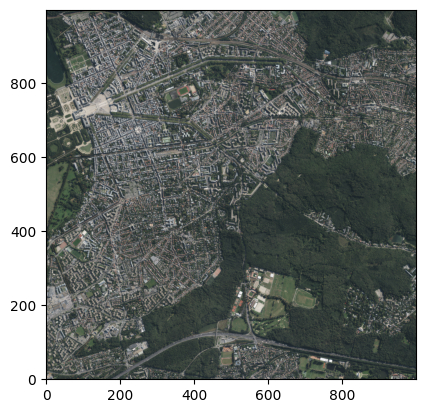

In [23]:
from shapely.geometry import Polygon, Point, MultiPolygon
import imageio, os.path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

url = 's3://poc-automatic-land-parcel-recognition/dataset-reference-fr/092/'
limit_dalles = 1
limit_parcels = 3

# Lecture du fichier contenant les dalles
with open(url + 'dalles.shp', 'rb', transport_params = {'client': session.client('s3')}) as dalleshp, open(url + 'dalles.dbf', 'rb', transport_params = {'client': session.client('s3')}) as dalledbf, open(url + 'dalles.prj', 'rb', transport_params = {'client': session.client('s3')}) as dalleprj:
    dallerdr = shapefile.Reader(shp=dalleshp, dbf=dalledbf, prj=dalleprj)

    # Lecture du fichier contenant les parcelles
    with open(url + 'parcelles.shp', 'rb', transport_params = {'client': session.client('s3')}) as parcelleshp, open(url + 'parcelles.dbf', 'rb', transport_params = {'client': session.client('s3')}) as parcelledbf, open(url + 'parcelles.prj', 'rb', transport_params = {'client': session.client('s3')}) as parcelleprj:
        parcelrdr = shapefile.Reader(shp=parcelleshp, dbf=parcelledbf, prj=parcelleprj)

        # On parcours les dalles
        for m in range(0, min(limit_dalles, dallerdr.numRecords)):

            # On fabrique un objet polygone avec les points de notre dalle
            poly = Polygon(dallerdr.shape(m).points)

            # On charge une petite version de l'image
            img = np.array(Image.open('workspace/92-2021-0635-6860-LA93-0M20-E080.png'), dtype = np.uint8)
            fig, ax = plt.subplots(1)
            ax.imshow(img, origin='lower')
            

            # On affiche les informations sur la dalle et l'image correspondante
            height, width = [ 1000, 1000 ] # Normalement 25000, 25000
            image = dallerdr.record(m)[0].replace('./', '')
            print("Image                                     : " + image)
            print("Format                                    : JPEG 2000")
            print("Dimensions de l'image                     : " + str(width) + "px x " + str(height) + "px")
            print("Système de coordonnées de référence (SCR) : EPSG:2154 - RGF93 v1 / Lambert-93")
            print("Coordonnées des bornes de l'image         : " + str(poly))
            origin = [ poly.boundary.bounds[0], poly.boundary.bounds[1] ]
            print("Origine en bas à gauche (en mètre)        : " + str(origin))
            bounds = [ poly.boundary.bounds[2] - poly.boundary.bounds[0], poly.boundary.bounds[3] - poly.boundary.bounds[1] ]
            print("Dimensions de l'image (en mètre)          : " + str(bounds))

            # Le système de coordonnées Lambert 93 est assez simple : les coordonnées sont exprimées en mètres linéaires
            # à partir d'un origine en bas à gauche du cadre concerné.
            # Voir https://epsg.io/2154
            # Pour déterminer les coordonnées X,Y en pixel des parcelles, on applique pour le moment un produit en croix
            scale = [ width / (poly.boundary.bounds[2] - poly.boundary.bounds[0]), height / (poly.boundary.bounds[3] - poly.boundary.bounds[1]) ]
            print("Echelle (en mètres pour 1px)              : " + str(scale))
            
            collection = []

            # On parcours les parcelles pour trouver celles incluses dans la dalle
            for n in range(0, min(limit_parcels, parcelrdr.numRecords)):
                
                inside = 0
                outside = 0
                parcel = parcelrdr.shape(n)
                for p in parcel.points:
                    if (poly.contains(Point(p))):
                        inside += 1
                    else:
                        outside += 1

                # On ignore les parcelles en dehors ou à cheval entre deux dalles
                if (inside == 0 or outside > 0):
                    continue

                print(" - Parcelle                                        : " + str(parcel))
                #print("   Coordonnées 1 en mètres                         : " + str(parcel.points[0]))
                #coord = [ parcel.points[0][0] - origin[0], parcel.points[0][1] - origin[1] ]
                #print("   Coordonnées 1 en mètres par rapport à l'origine : " + str(coord))
                #point = [ coord[0] * scale[0], coord[1] * scale[1] ]
                #print("   Coordonnées 1 en pixel par rapport à l'origine  : " + str(point))

                points = []
                for p in parcel.points:
                    coord = [ p[0] - origin[0], p[1] - origin[1] ]
                    point = [ coord[0] * scale[0], coord[1] * scale[1] ]
                    print(point)
                    #points.append(point)
                    points.append(coord[0] * scale[0])
                    points.append(coord[1] * scale[1])
                collection.append(patches.Polygon(point, True, edgecolor='r'))

            ax.add_collection(PatchCollection(collection, alpha=0.4))
            plt.show()

